In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
import pickle


from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
path = 'C:/Users/caiqu/OneDrive/Competitions/sony/input/'

In [4]:
# Reading Data
df_train = pd.read_csv(path+'df_train_under.csv')
df_test = pd.read_csv(path+'df_test.csv')
df_valid = pd.read_csv(path+'df_validation_under.csv')

In [5]:
#selecting text columns
text_columns = ['PLOT_SUMMARY', 'PLOT_OUTLINE', 'PLOT_MEDIUM', 'SRC_TITLE_NM']

### Text Pre-process

In [6]:
# Pré-processamento dos textos e tokenização
def preprocess_text(text):
    return simple_preprocess(text)

# Função para calcular a média dos vetores de palavras em um texto
def text_to_vector(text, model):
    vectors = [model.wv[word] for word in text if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)
    
    
# Dicionário para armazenar os modelos Word2Vec
word2vec_models = {}

# Loop sobre as colunas textuais
for column in text_columns:
    # Extrair os textos da coluna
    texts = df_train[column].astype(str).tolist()
    
    # Tokenizar os textos
    tokens = [preprocess_text(text) for text in texts]
    
    # Treinar o modelo Word2Vec
    word2vec_model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4)
    
    # Armazenar o modelo no dicionário
    word2vec_models[column] = word2vec_model

    # Aplicar a função para converter textos em vetores e criar uma nova coluna no DataFrame
    df_train[f'{column}_VECTOR'] = df_train[column].astype(str).apply(lambda text: text_to_vector(preprocess_text(text), word2vec_model))
    
    
    # Dicionário para armazenar os modelos Word2Vec
word2vec_models = {}

# Loop sobre as colunas textuais
for column in text_columns:
    # Extrair os textos da coluna
    texts = df_test[column].astype(str).tolist()
    
    # Tokenizar os textos
    tokens = [preprocess_text(text) for text in texts]
    
    # Treinar o modelo Word2Vec
    word2vec_model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4)
    
    # Armazenar o modelo no dicionário
    word2vec_models[column] = word2vec_model

    # Aplicar a função para converter textos em vetores e criar uma nova coluna no DataFrame
    df_test[f'{column}_VECTOR'] = df_test[column].astype(str).apply(lambda text: text_to_vector(preprocess_text(text), word2vec_model))
    
# Loop sobre as colunas textuais
for column in text_columns:
    # Extrair os textos da coluna
    texts = df_valid[column].astype(str).tolist()
    
    # Tokenizar os textos
    tokens = [preprocess_text(text) for text in texts]
    
    # Treinar o modelo Word2Vec
    word2vec_model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4)
    
    # Armazenar o modelo no dicionário
    word2vec_models[column] = word2vec_model

    # Aplicar a função para converter textos em vetores e criar uma nova coluna no DataFrame
    df_valid[f'{column}_VECTOR'] = df_valid[column].astype(str).apply(lambda text: text_to_vector(preprocess_text(text), word2vec_model))
    

In [7]:
# Loop sobre as colunas textuais
for column in text_columns:
    # Expandir a coluna de vetores em colunas separadas
    df_train = pd.concat([df_train.drop(columns=[f'{column}_VECTOR']), 
                          pd.DataFrame(df_train[f'{column}_VECTOR'].tolist(), 
                                       columns=[f'{column}_VECTOR_{i}' for i in range(100)])], axis=1)
    
# Loop sobre as colunas textuais
for column in text_columns:
    # Expandir a coluna de vetores em colunas separadas
    df_test = pd.concat([df_test.drop(columns=[f'{column}_VECTOR']), 
                          pd.DataFrame(df_test[f'{column}_VECTOR'].tolist(), 
                                       columns=[f'{column}_VECTOR_{i}' for i in range(100)])], axis=1)
    
# Loop sobre as colunas textuais
for column in text_columns:
    # Expandir a coluna de vetores em colunas separadas
    df_valid = pd.concat([df_valid.drop(columns=[f'{column}_VECTOR']), 
                          pd.DataFrame(df_valid[f'{column}_VECTOR'].tolist(), 
                                       columns=[f'{column}_VECTOR_{i}' for i in range(100)])], axis=1)

### PCA Extraction from Text Vectors

In [8]:
def apply_pca(df):
    # Selecionar colunas que contêm '_VECTOR'
    vector_columns = [col for col in df.columns if '_VECTOR' in col]

    # Criar matriz com os vetores das colunas selecionadas
    vectors_matrix = df[vector_columns].values

    # Aplicar PCA
    pca = PCA(n_components=15)  # Manter 95% da variância explicada
    pca_result = pca.fit_transform(vectors_matrix)

    # Adicionar colunas de PCA ao DataFrame
    for i in range(pca_result.shape[1]):
        df[f'PCA_{i+1}'] = pca_result[:, i]

    # Remover colunas com sufixo '_VECTOR'
    df = df.drop(columns=[col for col in df.columns if '_VECTOR' in col])

    return df

In [9]:
# Exemplo de uso
df_train = apply_pca(df_train)
df_valid = apply_pca(df_valid)
df_test = apply_pca(df_test)

In [10]:
df_train['SRC_GENRE_ENCODED'].value_counts()

8.0     2966
7.0     2692
5.0     2159
1.0     1070
10.0     666
6.0      412
2.0      270
3.0      243
12.0     235
4.0      183
11.0     126
9.0       92
Name: SRC_GENRE_ENCODED, dtype: int64

In [11]:
# df_train.head()

### Selecting and filtring Features for the Model

In [12]:
#Select Features
columns_to_drop = ['PLOT_OUTLINE_SENTIMENT', 'PLOT_MEDIUM_SENTIMENT', 'PLOT_SUMMARY_SENTIMENT', 'SRC_TITLE_NM_SENTIMENT',
'SRC_TITLE_ID', 'SRC_TITLE_NM', 'TITLE_TYPE', 'RELEASE_DT', 'PLOT_OUTLINE', 'PLOT_MEDIUM', 'PLOT_SUMMARY', 'SRC_GENRE']

# Remover as colunas dos conjuntos de treinamento e teste
df_train.drop(columns=columns_to_drop, inplace=True)
df_valid.drop(columns=columns_to_drop, inplace=True)

In [13]:
columns_to_drop = ['PLOT_OUTLINE_SENTIMENT', 'PLOT_MEDIUM_SENTIMENT', 'PLOT_SUMMARY_SENTIMENT', 'SRC_TITLE_NM_SENTIMENT',
'SRC_TITLE_ID', 'SRC_TITLE_NM', 'TITLE_TYPE', 'RELEASE_DT', 'PLOT_OUTLINE', 'PLOT_MEDIUM', 'PLOT_SUMMARY']

df_test.drop(columns=columns_to_drop, inplace=True)

In [14]:
df_train.head()

,ID,TITLE_YR,RUN_TIME,RATING_AVG,NO_OF_VOTES,BUDGET_AMT,RELEASE_DAY,RELEASE_MONTH,PLOT_SUMMARY_SENTIMENT_ENCODED,SRC_TITLE_NM_SENTIMENT_ENCODED,PLOT_OUTLINE_SENTIMENT_ENCODED,PLOT_MEDIUM_SENTIMENT_ENCODED,PLOT_SUMMARY_DOMINANT_TOPIC,PLOT_OUTLINE_DOMINANT_TOPIC,PLOT_MEDIUM_DOMINANT_TOPIC,SRC_TITLE_NM_DOMINANT_TOPIC,SRC_GENRE_ENCODED,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27,PCA_28,PCA_29,PCA_30,PCA_31,PCA_32,PCA_33,PCA_34,PCA_35,PCA_36,PCA_37,PCA_38,PCA_39,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49,PCA_50,PCA_51,PCA_52,PCA_53,PCA_54,PCA_55,PCA_56,PCA_57,PCA_58,PCA_59,PCA_60,PCA_61,PCA_62,PCA_63,PCA_64,PCA_65,PCA_66,PCA_67,PCA_68,PCA_69,PCA_70,PCA_71,PCA_72,PCA_73,PCA_74,PCA_75
0,2632,2019,90.0,0.50,1576,130000.0,6.0,11.0,1.0,3.0,1.0,1.0,1,7,9,6,7.0,0.419441,-1.068671,0.840423,-0.677320,-0.491017,0.240390,0.136614,0.310203,0.352351,-0.321893,0.190191,-0.133828,-0.114797,0.266355,-0.013827,-0.058998,-0.277772,-0.044628,-0.285703,-0.095819,0.055627,0.134677,0.071370,0.023420,-0.056111,-0.222874,-0.069700,0.009987,0.075087,-0.150904,-0.011418,0.059356,0.066475,-0.106109,0.067126,0.091656,-0.015246,0.008990,-0.089334,0.041744,0.139094,0.014061,-0.002594,0.065583,0.002237,-0.032178,-0.010490,0.000286,0.003428,0.036671,-0.029997,0.019717,-0.019539,-0.055955,0.014693,-0.051801,-0.042080,0.066558,0.052099,-0.019003,-0.035868,0.038656,0.008676,0.012446,-0.004807,0.071607,0.007783,-0.043281,0.021221,-0.023137,-0.019530,-0.029243,0.011171,-0.016116,0.032866
1,927,2019,121.0,0.61,2981,300000.0,17.0,1.0,1.0,1.0,2.0,1.0,8,0,9,7,5.0,-3.296877,1.244819,0.523896,0.142305,-0.375203,0.162956,0.062782,-0.121253,0.197824,-0.196496,0.046847,-0.120807,0.150065,-0.005472,0.108751,-0.069228,-0.045717,-0.044031,-0.015479,-0.055855,0.043283,-0.069647,0.049141,-0.094570,-0.054668,-0.015358,-0.069294,-0.079795,0.001718,-0.008311,-0.028240,0.039233,0.063657,0.074202,-0.021611,-0.002084,0.017257,-0.020808,-0.029341,0.047767,-0.032727,0.002901,0.025586,0.014524,-0.008178,0.034813,0.007739,0.037819,-0.043931,0.005557,0.043356,0.006577,-0.018161,-0.016483,0.001493,-0.002716,-0.023339,0.004800,-0.015991,0.015433,0.003652,0.015540,-0.009219,-0.025843,0.004820,0.011501,-0.002866,0.013150,-0.014646,0.005935,0.006946,-0.000551,0.011747,0.010221,0.012717
2,1276,2021,90.0,0.78,18,300000.0,10.0,6.0,1.0,2.0,1.0,2.0,6,4,0,1,5.0,2.494223,1.340315,-0.469430,0.101125,-0.149214,0.031120,-0.018290,-0.377642,0.044225,0.217920,-0.218851,0.074959,0.069728,-0.166166,0.042899,0.097433,0.162169,-0.066707,0.009349,-0.137334,0.068892,-0.036155,0.046476,-0.028198,-0.021292,0.083732,-0.076371,0.029188,0.015955,0.002849,-0.042912,0.006336,-0.033788,0.021014,0.011252,-0.032279,-0.014588,0.055668,-0.001835,-0.004547,-0.012317,-0.009202,-0.010808,0.017982,-0.030941,-0.005364,0.002980,-0.004521,-0.027019,-0.017834,-0.013202,0.012981,0.005097,0.006950,0.021194,-0.015649,-0.018303,-0.006472,0.014894,-0.010731,0.001454,0.003809,-0.014874,0.004704,0.016015,-0.000307,0.013245,0.007566,-0.002479,0.013339,0.007265,0.004805,-0.013524,-0.016542,-0.009855
3,2216,2019,97.0,0.60,1538,300000.0,22.0,6.0,1.0,2.0,1.0,3.0,2,3,6,0,8.0,0.191915,-1.640919,-0.496837,-0.268795,-0.781479,0.245343,0.070377,-0.371080,-0.201722,-0.185004,0.035712,0.085818,-0.012148,0.153553,0.082366,0.096542,0.162617,0.065625,0.044221,0.070529,0.026000,-0.010281,0.305187,0.038056,0.033546,-0.189220,0.109973,0.078933,-0.011529,0.190423,0.082135,0.130191,0.131997,-0.056747,-0.009658,0.050614,0.013752,-0.056472,0.030802,-0.043607,0.045384,-0.062381,0.063973,-0.034761,-0.022987,-0.045892,-0.082963,0.036091,-0.005124,0.013437,0.043308,-0.077370,-0.036631,0.074424,0.024113,0.034883,-0.021716,-0.043171,0.010928,-0.007588,-0.005209,0.017918,-0.000288,-0.002246,0.025855,0.022883,-0.017258,0.030830,0.018579,0.013555,0.020733,0.006182,-0.007148,0.002125,0.007284
4,1709,2011,60.0,0.7

### LGBM Modelling

In [15]:
# Separar features e target
X = df_train.drop(columns=['SRC_GENRE_ENCODED'])
y = df_train['SRC_GENRE_ENCODED']

In [16]:
# Dividir os dados em treino e validação
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
df_train.head()

,ID,TITLE_YR,RUN_TIME,RATING_AVG,NO_OF_VOTES,BUDGET_AMT,RELEASE_DAY,RELEASE_MONTH,PLOT_SUMMARY_SENTIMENT_ENCODED,SRC_TITLE_NM_SENTIMENT_ENCODED,PLOT_OUTLINE_SENTIMENT_ENCODED,PLOT_MEDIUM_SENTIMENT_ENCODED,PLOT_SUMMARY_DOMINANT_TOPIC,PLOT_OUTLINE_DOMINANT_TOPIC,PLOT_MEDIUM_DOMINANT_TOPIC,SRC_TITLE_NM_DOMINANT_TOPIC,SRC_GENRE_ENCODED,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27,PCA_28,PCA_29,PCA_30,PCA_31,PCA_32,PCA_33,PCA_34,PCA_35,PCA_36,PCA_37,PCA_38,PCA_39,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49,PCA_50,PCA_51,PCA_52,PCA_53,PCA_54,PCA_55,PCA_56,PCA_57,PCA_58,PCA_59,PCA_60,PCA_61,PCA_62,PCA_63,PCA_64,PCA_65,PCA_66,PCA_67,PCA_68,PCA_69,PCA_70,PCA_71,PCA_72,PCA_73,PCA_74,PCA_75
0,2632,2019,90.0,0.50,1576,130000.0,6.0,11.0,1.0,3.0,1.0,1.0,1,7,9,6,7.0,0.419441,-1.068671,0.840423,-0.677320,-0.491017,0.240390,0.136614,0.310203,0.352351,-0.321893,0.190191,-0.133828,-0.114797,0.266355,-0.013827,-0.058998,-0.277772,-0.044628,-0.285703,-0.095819,0.055627,0.134677,0.071370,0.023420,-0.056111,-0.222874,-0.069700,0.009987,0.075087,-0.150904,-0.011418,0.059356,0.066475,-0.106109,0.067126,0.091656,-0.015246,0.008990,-0.089334,0.041744,0.139094,0.014061,-0.002594,0.065583,0.002237,-0.032178,-0.010490,0.000286,0.003428,0.036671,-0.029997,0.019717,-0.019539,-0.055955,0.014693,-0.051801,-0.042080,0.066558,0.052099,-0.019003,-0.035868,0.038656,0.008676,0.012446,-0.004807,0.071607,0.007783,-0.043281,0.021221,-0.023137,-0.019530,-0.029243,0.011171,-0.016116,0.032866
1,927,2019,121.0,0.61,2981,300000.0,17.0,1.0,1.0,1.0,2.0,1.0,8,0,9,7,5.0,-3.296877,1.244819,0.523896,0.142305,-0.375203,0.162956,0.062782,-0.121253,0.197824,-0.196496,0.046847,-0.120807,0.150065,-0.005472,0.108751,-0.069228,-0.045717,-0.044031,-0.015479,-0.055855,0.043283,-0.069647,0.049141,-0.094570,-0.054668,-0.015358,-0.069294,-0.079795,0.001718,-0.008311,-0.028240,0.039233,0.063657,0.074202,-0.021611,-0.002084,0.017257,-0.020808,-0.029341,0.047767,-0.032727,0.002901,0.025586,0.014524,-0.008178,0.034813,0.007739,0.037819,-0.043931,0.005557,0.043356,0.006577,-0.018161,-0.016483,0.001493,-0.002716,-0.023339,0.004800,-0.015991,0.015433,0.003652,0.015540,-0.009219,-0.025843,0.004820,0.011501,-0.002866,0.013150,-0.014646,0.005935,0.006946,-0.000551,0.011747,0.010221,0.012717
2,1276,2021,90.0,0.78,18,300000.0,10.0,6.0,1.0,2.0,1.0,2.0,6,4,0,1,5.0,2.494223,1.340315,-0.469430,0.101125,-0.149214,0.031120,-0.018290,-0.377642,0.044225,0.217920,-0.218851,0.074959,0.069728,-0.166166,0.042899,0.097433,0.162169,-0.066707,0.009349,-0.137334,0.068892,-0.036155,0.046476,-0.028198,-0.021292,0.083732,-0.076371,0.029188,0.015955,0.002849,-0.042912,0.006336,-0.033788,0.021014,0.011252,-0.032279,-0.014588,0.055668,-0.001835,-0.004547,-0.012317,-0.009202,-0.010808,0.017982,-0.030941,-0.005364,0.002980,-0.004521,-0.027019,-0.017834,-0.013202,0.012981,0.005097,0.006950,0.021194,-0.015649,-0.018303,-0.006472,0.014894,-0.010731,0.001454,0.003809,-0.014874,0.004704,0.016015,-0.000307,0.013245,0.007566,-0.002479,0.013339,0.007265,0.004805,-0.013524,-0.016542,-0.009855
3,2216,2019,97.0,0.60,1538,300000.0,22.0,6.0,1.0,2.0,1.0,3.0,2,3,6,0,8.0,0.191915,-1.640919,-0.496837,-0.268795,-0.781479,0.245343,0.070377,-0.371080,-0.201722,-0.185004,0.035712,0.085818,-0.012148,0.153553,0.082366,0.096542,0.162617,0.065625,0.044221,0.070529,0.026000,-0.010281,0.305187,0.038056,0.033546,-0.189220,0.109973,0.078933,-0.011529,0.190423,0.082135,0.130191,0.131997,-0.056747,-0.009658,0.050614,0.013752,-0.056472,0.030802,-0.043607,0.045384,-0.062381,0.063973,-0.034761,-0.022987,-0.045892,-0.082963,0.036091,-0.005124,0.013437,0.043308,-0.077370,-0.036631,0.074424,0.024113,0.034883,-0.021716,-0.043171,0.010928,-0.007588,-0.005209,0.017918,-0.000288,-0.002246,0.025855,0.022883,-0.017258,0.030830,0.018579,0.013555,0.020733,0.006182,-0.007148,0.002125,0.007284
4,1709,2011,60.0,0.7

In [18]:
# Definir os parâmetros do modelo LGBM
params = {
    'objective': 'multiclass',
    'num_class': len(y.unique())+1,
    'metric': 'multi_logloss',
    'learning_rate': 0.001,
#     'num_leaves': 31,
#     'max_depth': -1,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
    'verbosity': -1,
    'seed': 42
}


# Criar conjunto de dados para treino e validação
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)



# Callbacks
callbacks = [
    lgb.log_evaluation(period = 500), lgb.early_stopping(stopping_rounds=150, first_metric_only=False, verbose=True)
]

# Treinar o modelo LGBM
model = lgb.train(params, train_data, num_boost_round=10000, valid_sets=[train_data, valid_data], callbacks=callbacks)


Training until validation scores don't improve for 150 rounds
[500]	training's multi_logloss: 1.42466	valid_1's multi_logloss: 1.72317
[1000]	training's multi_logloss: 1.16094	valid_1's multi_logloss: 1.63884
[1500]	training's multi_logloss: 0.982218	valid_1's multi_logloss: 1.5986
[2000]	training's multi_logloss: 0.849551	valid_1's multi_logloss: 1.57575
[2500]	training's multi_logloss: 0.7443	valid_1's multi_logloss: 1.56635
Early stopping, best iteration is:
[2792]	training's multi_logloss: 0.69215	valid_1's multi_logloss: 1.56482


### Exploring Training/Validating Phase

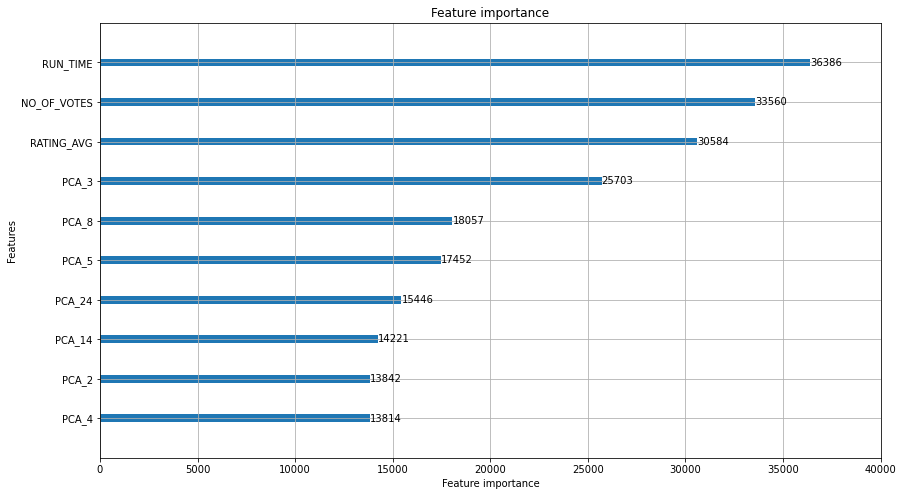

In [19]:
# Plotar a importância das features
lgb.plot_importance(model, figsize=(14, 8), max_num_features=10)
plt.show()

### Outsample Validation

In [20]:
# Fazer previsões para o conjunto de validação
predictions = model.predict(df_valid.drop(columns=['SRC_GENRE_ENCODED']), num_iteration=model.best_iteration)
df_valid['predictions'] = np.argmax(predictions, axis=1)  # Assumindo que você deseja adicionar a classe prevista com a maior probabilidade

In [21]:
# Calcular a acurácia geral
overall_accuracy = accuracy_score(df_valid['SRC_GENRE_ENCODED'], df_valid['predictions'])
print("Overall Accuracy:", overall_accuracy)

# Calcular a matriz de confusão
cm = confusion_matrix(df_valid['SRC_GENRE_ENCODED'], df_valid['predictions'])

# Obter os gêneros únicos
unique_genres = df_valid['SRC_GENRE_ENCODED'].unique()

# Calcular a acurácia por gênero
genre_accuracies = {}
for genre in unique_genres:
    mask = df_valid['SRC_GENRE_ENCODED'] == genre
    genre_accuracy = accuracy_score(df_valid['SRC_GENRE_ENCODED'][mask], df_valid['predictions'][mask])
    genre_accuracies[genre] = genre_accuracy

# Imprimir acurácia por gênero
for genre, accuracy in genre_accuracies.items():
    print(f"Accuracy for Genre {genre}: {accuracy}")

Overall Accuracy: 0.4503424657534247
Accuracy for Genre 8.0: 0.5878787878787879
Accuracy for Genre 5.0: 0.2711864406779661
Accuracy for Genre 6.0: 0.0
Accuracy for Genre 10.0: 0.43333333333333335
Accuracy for Genre 7.0: 0.8248175182481752
Accuracy for Genre 1.0: 0.16
Accuracy for Genre 3.0: 0.0
Accuracy for Genre 2.0: 0.0
Accuracy for Genre 12.0: 0.0
Accuracy for Genre 4.0: 0.0
Accuracy for Genre 9.0: 0.0
Accuracy for Genre 11.0: 0.0


### Predctions for Test_set

In [22]:
predictions = model.predict(df_test, num_iteration=model.best_iteration)

In [23]:
df_test['predictions'] = np.argmax(predictions, axis=1) 

In [24]:
def decode_predictions(df, column_name, encoder):
    # Crie uma cópia do DataFrame para evitar alterações indesejadas
    df_decoded = df.copy()
    
    # Use o encoder fornecido para decodificar os valores
    df_decoded[f"{column_name}_DECODED"] = encoder.inverse_transform(df[[column_name]]-1)
    
    return df_decoded

In [25]:
df_train = pd.read_csv(path+'df_train_under.csv')
encoder = OrdinalEncoder()
encoder.fit(df_train[['SRC_GENRE']])

OrdinalEncoder()

In [26]:
df_test = decode_predictions(df_test, 'predictions', encoder)

In [27]:
df_test[[ 'ID','predictions_DECODED']].to_csv('output/LGBM_US_test_set_predctions.csv', index=False)